# Introduction

Hello, I'm **Wesley**, nice to meet you! 👋

I've recently stumbled upon a very comprehensive dataset on measurement of hate speech from my alma mater, UC Berkeley. It aggregated social media comments from Youtube, Reddit, and Twitter.

The interesting thing about the dataset is the annotator's profile with attributes such as ideology, income, race, and etc. is included in the dataset. This is, unfortunately, uncommon in most social media dataset and so I was intrigued about this.
I also find the paper's idea of data perspectivism interesting as it argues that the disagreement of the annotator on the attributes of a hate speech is informative, rather than throwing it away.

![hate-speech-distribution.png](attachment:5919aace-8272-470d-a918-ddead4c15432.png)

Although, we are not leveraging the annotator's information in this notebook, I encourage you to explore the dataset and maybe leverage the annotator's information to make variations of this classifier.

Here we'll making a **Hate Speech MultiLabel Classifier** to classify hate speech to independent targets of race, religion, origin, gender, sexuality, age, disability by doing [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) on [BERT](https://huggingface.co/docs/transformers/model_doc/bert) with the [UC Berkeley D-Lab's Hate Speech Dataset](https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech) from the paper [The Measuring Hate Speech Corpus: Leveraging Rasch Measurement Theory for Data Perspectivism](https://aclanthology.org/2022.nlperspectives-1.11.pdf).

To try out the model without running the notebook, check out my inference endpoint at [HuggingFace](https://huggingface.co/wesleyacheng/hate-speech-multilabel-classification-with-bert?text=Confined+to+a+wheelchair.).

# Setup Python Libraries

In [1]:
%%bash
pip install numpy torch datasets transformers~=4.28.0 evaluate tqdm --quiet
pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

# Create Custom Dataset

## Clone Raw Dataset

In [2]:
from datasets import load_dataset

# clone dataset
# source: https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speech
raw_datasets = load_dataset("ucberkeley-dlab/measuring-hate-speech")

print(f"Number of Columns: {raw_datasets['train'].num_columns}")
print(f"Number of Rows: {raw_datasets['train'].num_rows}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Number of Columns: 131
Number of Rows: 135556


## Clean Target Labels

In [3]:
# keep only text and specific targets
raw_columns = raw_datasets['train'].column_names
keep_columns = ['text', 'target_race', 'target_religion', 'target_origin', 'target_gender', 'target_sexuality', 'target_age', 'target_disability']
remove_columns = set(raw_columns)-set(keep_columns)

preprocessed_datasets = raw_datasets.remove_columns(remove_columns)
preprocessed_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'target_race', 'target_religion', 'target_origin', 'target_gender', 'target_sexuality', 'target_age', 'target_disability'],
        num_rows: 135556
    })
})

In [4]:
column_mapping = {column:column.split('_')[1] for column in keep_columns if column.startswith('target')}
print(f"COLUMN_MAPPING: {column_mapping}")

preprocessed_datasets = preprocessed_datasets.rename_columns(column_mapping)
preprocessed_datasets

COLUMN_MAPPING: {'target_race': 'race', 'target_religion': 'religion', 'target_origin': 'origin', 'target_gender': 'gender', 'target_sexuality': 'sexuality', 'target_age': 'age', 'target_disability': 'disability'}


DatasetDict({
    train: Dataset({
        features: ['text', 'race', 'religion', 'origin', 'gender', 'sexuality', 'age', 'disability'],
        num_rows: 135556
    })
})

In [5]:
# get two-way label and label id
ID2LABEL = {}
LABEL2ID = {}

label_id = 0
for label in preprocessed_datasets['train'].features.keys():
    if label in ['text']:
        continue

    ID2LABEL[label_id] = label
    LABEL2ID[label] = label_id

    label_id += 1

print(f"ID2LABEL:\n{ID2LABEL}\n")
print(f"LABEL2ID:\n{LABEL2ID}")

ID2LABEL:
{0: 'race', 1: 'religion', 2: 'origin', 3: 'gender', 4: 'sexuality', 5: 'age', 6: 'disability'}

LABEL2ID:
{'race': 0, 'religion': 1, 'origin': 2, 'gender': 3, 'sexuality': 4, 'age': 5, 'disability': 6}


## Explore Dataset

In [6]:
# get target label counts and percentages
label_counts = {}
label_percentages = {}

for label in LABEL2ID:
    label_counts[label] = sum(preprocessed_datasets['train'][label])
    label_percentages[label] = float(f"{sum(preprocessed_datasets['train'][label]) / len(preprocessed_datasets['train'])*100:.2f}")

print(f"LABEL_COUNTS:\n{label_counts}\n")
print(f"LABEL_PERCENTAGES:\n{label_percentages}")

LABEL_COUNTS:
{'race': 48352, 'religion': 26182, 'origin': 24372, 'gender': 40439, 'sexuality': 22407, 'age': 2005, 'disability': 3716}

LABEL_PERCENTAGES:
{'race': 35.67, 'religion': 19.31, 'origin': 17.98, 'gender': 29.83, 'sexuality': 16.53, 'age': 1.48, 'disability': 2.74}


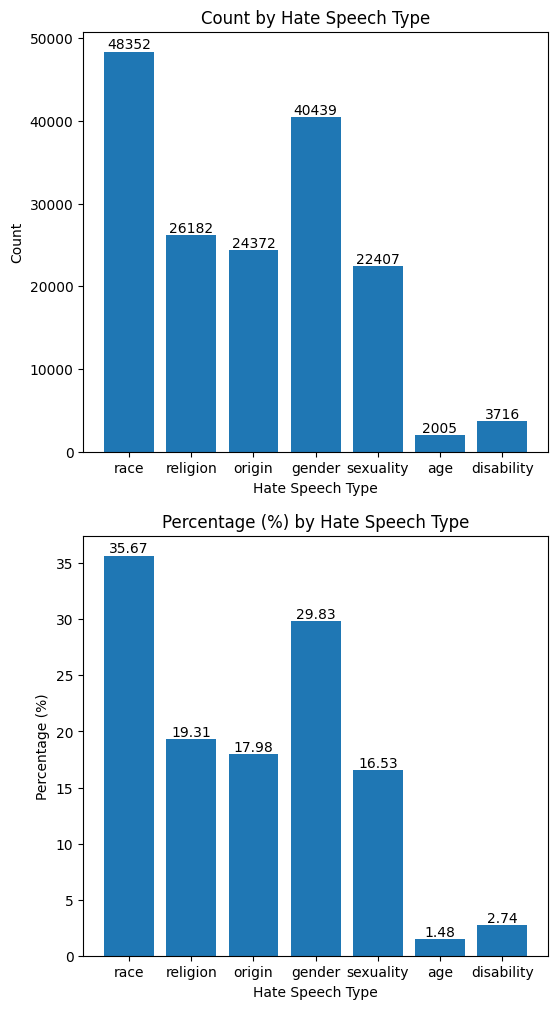

In [7]:
import matplotlib.pyplot as plt

# create 2 graphs
fig, axs = plt.subplots(2, figsize=(6,12))

# create bar graphs of label counts
bar_container0 = axs[0].bar(label_counts.keys(), label_counts.values())
axs[0].bar_label(bar_container0, label_type='edge')
axs[0].set_xlabel('Hate Speech Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Count by Hate Speech Type')

# create bar graphs of label percentages
bar_container1 = axs[1].bar(label_percentages.keys(), label_percentages.values())
axs[1].bar_label(bar_container1, label_type='edge')
axs[1].set_xlabel('Hate Speech Type')
axs[1].set_ylabel('Percentage (%)')
axs[1].set_title('Percentage (%) by Hate Speech Type')

plt.show()

In [8]:
def create_labels(batch):
    # one-hot encode targets for training
    batch['labels'] = [[float(batch[label][i]) for label in LABEL2ID] for i in range(len(batch['text']))]
    return batch

preprocessed_datasets = preprocessed_datasets.map(create_labels, batched=True, remove_columns=LABEL2ID.keys())
preprocessed_datasets

Map:   0%|          | 0/135556 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 135556
    })
})

# Setup Model Training

## Create Train/Val/Test Dataset Splits

In [9]:
import numpy as np
import torch

# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [10]:
from datasets import DatasetDict

# train (80%), validation (10%), test (10%) split
train_test_datasets = preprocessed_datasets['train'].train_test_split(test_size=0.2, seed=SEED, shuffle=True)
validation_test_datasets = train_test_datasets['test'].train_test_split(test_size=0.5, seed=SEED, shuffle=True)

preprocessed_datasets = DatasetDict({
    'train': train_test_datasets['train'],
    'validation': validation_test_datasets['train'],
    'test': validation_test_datasets['test']
})
preprocessed_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 108444
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 13556
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 13556
    })
})

## Tokenize Dataset

In [11]:
from transformers import AutoTokenizer

CHECKPOINT = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
tokenized_datasets = preprocessed_datasets.map(lambda batch: tokenizer(batch['text'], truncation=True), batched=True, remove_columns=['text'])
tokenized_datasets

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/108444 [00:00<?, ? examples/s]

Map:   0%|          | 0/13556 [00:00<?, ? examples/s]

Map:   0%|          | 0/13556 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 108444
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 13556
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 13556
    })
})

## Setup DataLoaders

In [12]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

# get data collator for data loader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# setup dataloaders with tokenized dataset
# to shuffle only be train for each epoch
# in 64 batch sizes with dynamic padding

dataloaders = {}
for dataset_type in tokenized_datasets.keys():
    dataloaders[dataset_type] = DataLoader(
        dataset=tokenized_datasets[dataset_type],
        batch_size=64,
        shuffle=(dataset_type == 'train'),
        collate_fn=data_collator,
    )

## Get Current Device

In [13]:
# get current device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Clone UnFine-Tuned Model

In [14]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    CHECKPOINT,
    problem_type='multi_label_classification',
    num_labels=len(LABEL2ID),
    label2id=LABEL2ID,
    id2label=ID2LABEL,
)

# move model to device
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Setup Optimizer and Scheduler

In [15]:
from transformers import AdamW, get_scheduler

# setup optimizer and scheduler
scheduler_name = 'linear'
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0, no_deprecation_warning=True)
num_training_epochs = 1
num_training_steps = num_training_epochs * len(dataloaders['train'])
num_warmup_steps = 0
lr_scheduler = get_scheduler(
    name=scheduler_name,
    optimizer=optimizer,
    num_training_steps=num_training_steps,
    num_warmup_steps=num_warmup_steps,
)

print(f"           SCHEDULER NAME: {scheduler_name}")
print(f"                OPTIMIZER: {optimizer.__class__.__name__}")
print(f"NUMBER OF TRAINING EPOCHS: {num_training_epochs}")
print(f" NUMBER OF TRAINING STEPS: {num_training_steps}")

           SCHEDULER NAME: linear
                OPTIMIZER: AdamW
NUMBER OF TRAINING EPOCHS: 1
 NUMBER OF TRAINING STEPS: 1695


## Setup Training Metrics

In [16]:
from sklearn.metrics import accuracy_score, f1_score

def samples_accuracy_score(y_true, y_pred):
    return np.sum(y_true==y_pred) / y_true.size

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = torch.nn.functional.sigmoid(torch.Tensor(logits))
    predictions = (predictions >= 0.50).int().numpy()
    samples_accuracy = samples_accuracy_score(labels, predictions)
    samples_f1 = f1_score(labels, predictions, average='samples', zero_division=0)
    return {
        'accuracy': samples_accuracy,
        'f1': samples_f1,
    }

## Setup Training and Evaluation Scripts

In [17]:
from tqdm.notebook import tqdm

def train(model, dataloader):
    # setup train metrics
    loss = 0
    train_predictions = []
    train_labels = []

    # set to train mode
    model.train()
    # iterate through dataloader
    for batch in tqdm(dataloader):
        # zero the gradients
        optimizer.zero_grad()

        # predict batch in current device
        batch.to(device)
        outputs = model(**batch)

        # compute multilabel outputs
        predictions = torch.nn.functional.sigmoid(outputs.logits).cpu()
        predictions = (predictions >= 0.50).int().numpy()
        labels = batch['labels']

        # backprop and update learning rate
        outputs.loss.backward()
        optimizer.step()
        lr_scheduler.step()

        # accumulate train metrics
        loss += outputs.loss.item()
        train_predictions += predictions.tolist()
        train_labels += labels.tolist()

    # compute train metrics
    loss /= len(dataloader)
    samples_accuracy = samples_accuracy_score(np.array(train_labels), np.array(train_predictions))
    samples_f1 = f1_score(np.array(train_labels), np.array(train_predictions), average='samples', zero_division=0)
    return {
        'loss': loss,
        'accuracy': samples_accuracy,
        'f1': samples_f1,
    }

In [18]:
def evaluate(model, dataloader):
    # setup evaluation metrics variables
    loss = 0
    evaluate_predictions = []
    evaluate_labels = []

    # set to evaluation mode
    model.eval()
    with torch.no_grad():
        # iterate through dataloader
        for batch in tqdm(dataloader):
            # predict batch in current device
            batch.to(device)
            outputs = model(**batch)

            # compute multilabel outputs
            predictions = torch.nn.functional.sigmoid(outputs.logits).cpu()
            predictions = (predictions >= 0.50).cpu().numpy()
            labels = batch['labels']

            # accumulate evaluation metrics
            loss += outputs.loss.item()
            evaluate_predictions += predictions.tolist()
            evaluate_labels += labels.tolist()

    # compute evaluation metrics
    loss /= len(dataloader)
    samples_accuracy = samples_accuracy_score(np.array(evaluate_labels), np.array(evaluate_predictions))
    samples_f1 = f1_score(np.array(evaluate_labels), np.array(evaluate_predictions), average='samples', zero_division=0)
    return {
        'loss': loss,
        'accuracy': samples_accuracy,
        'f1': samples_f1,
    }

# Train Model

## Get UnFine-Tuned Metrics

In [19]:
test_metrics = evaluate(model, dataloaders['test'])
print(f"TEST ACCURACY: {test_metrics['accuracy']:.5f}", end=" | ")
print(f"TEST F1: {test_metrics['f1']:.5f}")

  0%|          | 0/212 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TEST ACCURACY: 0.63523 | TEST F1: 0.20189


We got **Test Accuracy: 49%** and **Test F1: 16%**, which is not good.

Let's attempt transfer learning on **BERT**!

## Train the Model

In [20]:
for epoch in range(num_training_epochs):
    train_metrics = train(model, dataloaders['train'])
    validation_metrics = evaluate(model, dataloaders['validation'])

    print(f"EPOCH {epoch+1}", end=" | ")
    print(f"TRAIN LOSS: {train_metrics['loss']:.5f}", end=" | ")
    print(f"VALIDATION LOSS: {validation_metrics['loss']:.5f}", end=" | ")
    print(f"VALIDATION ACCURACY: {validation_metrics['accuracy']:.5f}", end=" | ")
    print(f"VALIDATION F1: {validation_metrics['f1']:.5f}")

  0%|          | 0/1695 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

EPOCH 1 | TRAIN LOSS: 0.17651 | VALIDATION LOSS: 0.15454 | VALIDATION ACCURACY: 0.93857 | VALIDATION F1: 0.83513


## Get Fine-Tuned Metrics

In [21]:
test_metrics = evaluate(model, dataloaders['test'])
print(f"TEST ACCURACY: {test_metrics['accuracy']:.5f}", end=" | ")
print(f"TEST F1: {test_metrics['f1']:.5f}")

  0%|          | 0/212 [00:00<?, ?it/s]

TEST ACCURACY: 0.93791 | TEST F1: 0.83065


We got **Test Accuracy: 93%** and **Test F1: 82%** in just **1 epoch**

# Let's try out some examples

**WARNING**: NSFW, and we **do not** condone any of these examples.

In [22]:
from transformers import pipeline

# setup pipeline as a text classification with multilabel outputs
hate_speech_multilabel_classifier = pipeline(
    task='text-classification',
    model=model,
    tokenizer=tokenizer,
    device=torch.cuda.current_device(),
    top_k=None
)

In [23]:
race_hate_text = """
Yellow peril.
"""

hate_speech_multilabel_classifier(race_hate_text)

[[{'label': 'race', 'score': 0.8519228100776672},
  {'label': 'origin', 'score': 0.14546367526054382},
  {'label': 'gender', 'score': 0.06759949028491974},
  {'label': 'sexuality', 'score': 0.02927064150571823},
  {'label': 'age', 'score': 0.024740267544984818},
  {'label': 'disability', 'score': 0.01703631691634655},
  {'label': 'religion', 'score': 0.013958151452243328}]]

In [24]:
religion_hate_text = """
Nietzsche said 'God is dead'.
"""

hate_speech_multilabel_classifier(religion_hate_text)

[[{'label': 'religion', 'score': 0.9613773822784424},
  {'label': 'gender', 'score': 0.024720825254917145},
  {'label': 'race', 'score': 0.02344806306064129},
  {'label': 'origin', 'score': 0.01791924051940441},
  {'label': 'disability', 'score': 0.016611402854323387},
  {'label': 'sexuality', 'score': 0.00900993961840868},
  {'label': 'age', 'score': 0.006767259910702705}]]

In [25]:
origin_hate_text = """
Go back to where you came from.
"""

hate_speech_multilabel_classifier(origin_hate_text)

[[{'label': 'origin', 'score': 0.9171758890151978},
  {'label': 'race', 'score': 0.26222267746925354},
  {'label': 'religion', 'score': 0.010825095698237419},
  {'label': 'gender', 'score': 0.010680872946977615},
  {'label': 'sexuality', 'score': 0.0060879322700202465},
  {'label': 'disability', 'score': 0.0050438703037798405},
  {'label': 'age', 'score': 0.003973505925387144}]]

In [26]:
gender_hate_text = """
You're being emotional.
"""

hate_speech_multilabel_classifier(gender_hate_text)

[[{'label': 'disability', 'score': 0.5680640935897827},
  {'label': 'gender', 'score': 0.18440639972686768},
  {'label': 'sexuality', 'score': 0.09197143465280533},
  {'label': 'age', 'score': 0.08817186951637268},
  {'label': 'origin', 'score': 0.06367406249046326},
  {'label': 'race', 'score': 0.0383901447057724},
  {'label': 'religion', 'score': 0.022399207577109337}]]

In [27]:
sexuality_hate_text = """
I identify as a sandwich.
"""

hate_speech_multilabel_classifier(sexuality_hate_text)

[[{'label': 'gender', 'score': 0.38573959469795227},
  {'label': 'sexuality', 'score': 0.27592629194259644},
  {'label': 'race', 'score': 0.18398648500442505},
  {'label': 'origin', 'score': 0.1361476629972458},
  {'label': 'age', 'score': 0.09595651179552078},
  {'label': 'religion', 'score': 0.08522583544254303},
  {'label': 'disability', 'score': 0.060177769511938095}]]

In [28]:
age_hate_text = """
Old fart.
"""

hate_speech_multilabel_classifier(age_hate_text)

[[{'label': 'age', 'score': 0.6444419622421265},
  {'label': 'gender', 'score': 0.26690900325775146},
  {'label': 'disability', 'score': 0.15907727181911469},
  {'label': 'sexuality', 'score': 0.15903279185295105},
  {'label': 'race', 'score': 0.08451423794031143},
  {'label': 'religion', 'score': 0.036672674119472504},
  {'label': 'origin', 'score': 0.030043642967939377}]]

In [29]:
disability_hate_text = """
Confined to a wheelchair.
"""

hate_speech_multilabel_classifier(disability_hate_text)

[[{'label': 'disability', 'score': 0.9034487009048462},
  {'label': 'gender', 'score': 0.10752930492162704},
  {'label': 'sexuality', 'score': 0.056955281645059586},
  {'label': 'origin', 'score': 0.027048232033848763},
  {'label': 'religion', 'score': 0.026598786935210228},
  {'label': 'age', 'score': 0.023158293217420578},
  {'label': 'race', 'score': 0.01370598841458559}]]

In [30]:
model.save_pretrained('./', from_pt=True)